# Generational changes in religious affiliaton, beliefs, and attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import MNLogit

In [2]:
import seaborn as sns
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1', 6)

In [3]:
import utils

from empiricaldist import Cdf

In [4]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()


In [5]:
def savefig(root, extension):
    filename = f"{root}.{extension}"
    plt.savefig(filename, dpi=600)

In [6]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [7]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

<IPython.core.display.Javascript object>

In [8]:
url = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/gss_religion.hdf"
download(url)

<IPython.core.display.Javascript object>

In [9]:
filename = "gss_religion.hdf"

gss = pd.read_hdf(filename, "gss")

<IPython.core.display.Javascript object>

In [10]:
gss["wtssall"].describe()

count    68846.000000
mean         1.000014
std          0.487046
min          0.172380
25%          0.550100
50%          0.970900
75%          1.098500
max          8.739876
Name: wtssall, dtype: float64

<IPython.core.display.Javascript object>

In [11]:
print(gss.shape)
gss.head()

(68846, 8)


,year,god,conclerg,bible,cohort,age,relig,wtssall
0,1972,NaN,NaN,NaN,1949.0,23.0,3.0,0.4446
1,1972,NaN,NaN,NaN,1902.0,70.0,2.0,0.8893
2,1972,NaN,NaN,NaN,1924.0,48.0,1.0,0.8893
3,1972,NaN,NaN,NaN,1945.0,27.0,5.0,0.8893
4,1972,NaN,NaN,NaN,1911.0,61.0,1.0,0.8893


<IPython.core.display.Javascript object>

Question 1: Interpretation of the bible https://gssdataexplorer.norc.org/projects/29853/variables/1076/vshow

In [12]:
gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)
sum(gss.bible.isnull())

33527

<IPython.core.display.Javascript object>

In [13]:
utils.values(gss, "bible")

1.0    11891
2.0    17005
3.0     6423
Name: bible, dtype: int64

<IPython.core.display.Javascript object>

Question 2: Confidence in the people running religious institutions https://gssdataexplorer.norc.org/projects/29853/variables/450/vshow

In [14]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.conclerg.isnull())

23771

<IPython.core.display.Javascript object>

In [15]:
utils.values(gss, "conclerg")

1.0    12075
2.0    23069
3.0     9931
Name: conclerg, dtype: int64

<IPython.core.display.Javascript object>

Question 3: Belief in God https://gssdataexplorer.norc.org/projects/29853/variables/1076/vshow

In [16]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

41577

<IPython.core.display.Javascript object>

In [17]:
utils.values(gss, "god")

1.0      955
2.0     1497
3.0     2925
4.0     1112
5.0     4499
6.0    16281
Name: god, dtype: int64

<IPython.core.display.Javascript object>

Question 4: Religious preference https://gssdataexplorer.norc.org/projects/29853/variables/287/vshow

In [18]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

376

<IPython.core.display.Javascript object>

In [19]:
utils.values(gss, "relig")

1.0     38707
2.0     16498
3.0      1360
4.0      8918
5.0      1135
6.0       245
7.0       130
8.0        41
9.0       178
10.0      155
11.0      915
12.0       34
13.0      154
Name: relig, dtype: int64

<IPython.core.display.Javascript object>

Age https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [20]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

561

<IPython.core.display.Javascript object>

Year of birth https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [21]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

561

<IPython.core.display.Javascript object>

Drop records if age or cohort is missing.

In [22]:
gss.dropna(subset=["age", "cohort"], inplace=True)
gss.shape

(68284, 8)

<IPython.core.display.Javascript object>

Here's the distribution of ages.

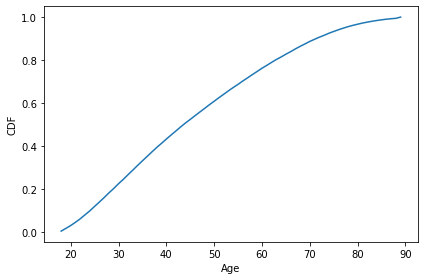

<IPython.core.display.Javascript object>

In [23]:
Cdf.from_seq(gss.age).plot()
decorate(xlabel="Age", ylabel="CDF")

Group people into 5-year age groups.

In [24]:
gss["age_group"] = utils.RoundIntoBins(gss, "age", 5) + 2.5

<IPython.core.display.Javascript object>

Here's the distribution of birth year.

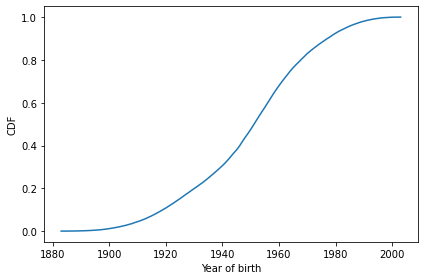

<IPython.core.display.Javascript object>

In [25]:
Cdf.from_seq(gss.cohort).plot()
decorate(xlabel="Year of birth", ylabel="CDF")

Group people into 5- and 10-year bins by birth year.

In [26]:
gss["cohort5"] = utils.RoundIntoBins(gss, "cohort", 5, low=4) + 2.5

<IPython.core.display.Javascript object>

In [27]:
grouped_cohort = gss.groupby(["cohort5"])
counts = grouped_cohort.relig.count()
counts

cohort5
1881.5       2
1886.5      37
1891.5     140
1896.5     365
1901.5     726
1906.5    1113
1911.5    1648
1916.5    2281
1921.5    2798
1926.5    3131
1931.5    3173
1936.5    3754
1941.5    4584
1946.5    6011
1951.5    6847
1956.5    6996
1961.5    6132
1966.5    4924
1971.5    3917
1976.5    3109
1981.5    2598
1986.5    1859
1991.5    1154
1996.5     549
2001.5     139
Name: relig, dtype: int64

<IPython.core.display.Javascript object>

In [28]:
gss["cohort10"] = utils.RoundIntoBins(gss, "cohort", 10, low=4)

<IPython.core.display.Javascript object>

In [29]:
grouped_cohort = gss.groupby(["cohort10"])
counts = grouped_cohort.relig.count()
counts

cohort10
1874.0        2
1884.0      177
1894.0     1091
1904.0     2761
1914.0     5079
1924.0     6304
1934.0     8338
1944.0    12858
1954.0    13128
1964.0     8841
1974.0     5707
1984.0     3013
1994.0      688
Name: relig, dtype: int64

<IPython.core.display.Javascript object>

Here's the number of respondents in each year.

In [30]:
utils.values(gss, "year")

1972    1608
1973    1500
1974    1478
1975    1485
1976    1493
1977    1523
1978    1525
1980    1459
1982    1845
1983    1592
1984    1467
1985    1527
1986    1463
1987    1807
1988    1477
1989    1533
1990    1372
1991    1514
1993    1601
1994    2986
1996    2898
1998    2827
2000    2809
2002    2751
2004    2803
2006    4492
2008    2013
2010    2041
2012    1969
2014    2529
2016    2857
2018    2341
2021    3699
Name: year, dtype: int64

<IPython.core.display.Javascript object>

## Recoding

Creating one-hots and categorical variables for the dependent variables.

In [31]:
def create_relig_vars(df):
    """Creates columns for religious categories.

    df: DataFrame
    """
    # lumping "Christian" with Protestant
    df["prot"] = df.relig.isin([1, 11]).astype(float)

    # lumping "Orthodox-Christian" with Catholic
    df["cath"] = df.relig.isin([2, 10]).astype(float)
    df["none"] = (df.relig == 4).astype(float)
    df["other"] = df.relig.isin([3, 5, 6, 7, 8, 9, 12, 13]).astype(float)

    # recoding relig4 with just 4 categories
    df["relig4"] = df.relig.copy()
    df.relig4.replace([11], 1, inplace=True)
    df.relig4.replace([10], 2, inplace=True)
    df.relig4.replace([5, 6, 7, 8, 9, 12, 13], 3, inplace=True)

    varnames = ["prot", "cath", "none", "other"]

    # anywhere relig is null, the recoded variables should be, too
    df.loc[df.relig.isnull(), varnames + ["relig4"]] = np.nan


create_relig_vars(gss)

<IPython.core.display.Javascript object>

In [32]:
sum(gss.relig.isnull())

297

<IPython.core.display.Javascript object>

In [33]:
utils.values(gss, "relig4")

1.0    39380
2.0    16548
3.0     3239
4.0     8820
Name: relig4, dtype: int64

<IPython.core.display.Javascript object>

In [34]:
def create_belief_vars(df):
    """Creates columns for belief categories.

    df: DataFrame
    """
    # reducing the number of categories to 3
    df["nobelief"] = (df.god.isin([1, 2])).astype(float)
    df["belief"] = (df.god.isin([3, 4, 5])).astype(float)
    df["strongbelief"] = (df.god.isin([6])).astype(float)

    df["belief3"] = df.god.copy()
    df.belief3.replace([1, 2], 1, inplace=True)
    df.belief3.replace([3, 4, 5], 2, inplace=True)
    df.belief3.replace([6], 3, inplace=True)

    varnames = ["strongbelief", "belief", "nobelief", "belief3"]
    df.loc[df.god.isnull(), varnames] = np.nan


create_belief_vars(gss)

<IPython.core.display.Javascript object>

In [35]:
sum(gss.god.isnull())

41264

<IPython.core.display.Javascript object>

In [36]:
utils.values(gss, "belief3")

1.0     2425
2.0     8476
3.0    16119
Name: belief3, dtype: int64

<IPython.core.display.Javascript object>

In [37]:
def create_conf_vars(df):
    """Creates columns for confidence in religion categories.

    df: DataFrame
    """
    df["confident"] = (df.conclerg == 1).astype(float)
    df["someconf"] = (df.conclerg == 2).astype(float)
    df["noconf"] = (df.conclerg == 3).astype(float)

    varnames = ["confident", "someconf", "noconf"]
    df.loc[df.conclerg.isnull(), varnames] = np.nan


create_conf_vars(gss)

<IPython.core.display.Javascript object>

In [38]:
sum(gss.conclerg.isnull())

23574

<IPython.core.display.Javascript object>

In [39]:
utils.values(gss, "conclerg")

1.0    12010
2.0    22868
3.0     9832
Name: conclerg, dtype: int64

<IPython.core.display.Javascript object>

In [40]:
def create_bible_vars(df):
    """Creates columns for bible interpretation categories.

    df: DataFrame
    """
    df["literal"] = (df.bible == 1).astype(float)
    df["inspired"] = (df.bible == 2).astype(float)
    df["legends"] = (df.bible == 3).astype(float)

    varnames = ["literal", "inspired", "legends"]
    df.loc[df.bible.isnull(), varnames] = np.nan


create_bible_vars(gss)

<IPython.core.display.Javascript object>

In [41]:
sum(gss.bible.isnull())

33058

<IPython.core.display.Javascript object>

In [42]:
utils.values(gss, "bible")

1.0    11853
2.0    16962
3.0     6411
Name: bible, dtype: int64

<IPython.core.display.Javascript object>

In [43]:
def center_factors(df):
    """Center factors around their means.

    Add centered factors to make the coeffients
    of the model easier to interpret.

    df: DataFrame
    """
    df["ones"] = np.ones_like(df.cohort)
    df["c"] = df.cohort - 1966
    df["y"] = df.year - 1990

    # df["c2"] = df["c"] ** 2
    # df["y2"] = df["y"] ** 2

<IPython.core.display.Javascript object>

In [44]:
center_factors(gss)

<IPython.core.display.Javascript object>

## Resample

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [45]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,god,conclerg,bible,cohort,age,relig,wtssall,age_group,cohort5,...,belief3,confident,someconf,noconf,literal,inspired,legends,ones,c,y
0,1972,NaN,NaN,NaN,1948.0,24.0,1.0,1.3339,22.5,1946.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-18.0,-18
1,1972,NaN,NaN,NaN,1952.0,20.0,1.0,1.3339,22.5,1951.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-14.0,-18
2,1972,NaN,NaN,NaN,1939.0,33.0,1.0,0.8893,32.5,1941.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-27.0,-18
3,1972,NaN,NaN,NaN,1947.0,25.0,2.0,0.8893,27.5,1946.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-19.0,-18
4,1972,NaN,NaN,NaN,1909.0,63.0,1.0,0.8893,62.5,1911.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-57.0,-18


<IPython.core.display.Javascript object>

### Run logistic models

One religion category at a time, as opposed to the multinomial models below.

In [46]:
formula = "prot ~ c + y"
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.666636
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                67955
Model:                          Logit   Df Residuals:                    67952
Method:                           MLE   Df Model:                            2
Date:                Sun, 28 Aug 2022   Pseudo R-squ.:                 0.02584
Time:                        10:08:26   Log-Likelihood:                -45301.
converged:                       True   LL-Null:                       -46503.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0489      0.013      3.889      0.000       0.024       0.074
c             -0.0169      0.000    -35.956      0.000      -0.018      -0.016
y             -0.0028      0.001     -4.149      0.000      -0.004      -0.002
==============================================================================
"""

<IPython.core.display.Javascript object>

In [47]:
year = [2020, 2030, 2020, 2030]
cohort = [1980, 1980, 1990, 1990]
new = pd.DataFrame(dict(year=year, cohort=cohort))
center_factors(new)

<IPython.core.display.Javascript object>

In [48]:
def model_predict(model, new):
    res = new.copy()
    res["pred"] = model.predict(new) * 100
    res["diff"] = res.pred - res.pred[0]
    return res[["cohort", "year", "pred", "diff"]]

<IPython.core.display.Javascript object>

In [49]:
model_predict(model, new)

,cohort,year,pred,diff
0,1980,2020,43.227486,0.000000
1,1980,2030,42.530745,-0.696742
2,1990,2020,39.143699,-4.083787
3,1990,2030,38.468180,-4.759306


<IPython.core.display.Javascript object>

In [50]:
formula = "none ~ c + y"
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.356975
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                67955
Model:                          Logit   Df Residuals:                    67952
Method:                           MLE   Df Model:                            2
Date:                Sun, 28 Aug 2022   Pseudo R-squ.:                 0.07430
Time:                        10:08:26   Log-Likelihood:                -24258.
converged:                       True   LL-Null:                       -26205.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7626      0.019    -92.676      0.000      -1.800      -1.725
c              0.0296      0.001     38.626      0.000       0.028       0.031
y              0.0134      0.001     12.411      0.000       0.011       0.016
==============================================================================
"""

<IPython.core.display.Javascript object>

In [51]:
model_predict(model, new)

,cohort,year,pred,diff
0,1980,2020,27.987242,0.000000
1,1980,2030,30.774783,2.787542
2,1990,2020,34.316357,6.329116
3,1990,2030,37.406831,9.419589


<IPython.core.display.Javascript object>

In [52]:
formula = "relig4 ~ c + y"
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.048628
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 relig4   No. Observations:                67955
Model:                        MNLogit   Df Residuals:                    67946
Method:                           MLE   Df Model:                            6
Date:                Sun, 28 Aug 2022   Pseudo R-squ.:                 0.03159
Time:                        10:08:29   Log-Likelihood:                -71259.
converged:                       True   LL-Null:                       -73584.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
  relig4=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6151      0.015    -41.859      0.000      -0.644      -0.586
c              0.0104      0.001     19.145      0.000       0.009       0.011
y             -0.0029      0.001     -3.652      0.000      -0.004      -0.001
------------------------------------------------------------------------------
  relig4=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2976      0.029    -78.789      0.000      -2.355      -2.240
c              0.0140      0.001     12.820      0.000       0.012       0.016
y              0.0072      0.002      4.523      0.000       0.004       0.010
------------------------------------------------------------------------------
  relig4=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2635      0.020    -63.963      0.000      -1.302      -1.225
c              0.0336      0.001     42.509      0.000       0.032       0.035
y              0.0131      0.001     11.703      0.000       0.011       0.015
==============================================================================
"""

<IPython.core.display.Javascript object>

In [53]:
from sklearn.linear_model import LogisticRegression

subset = sample.dropna(subset=["relig4", "c", "y"])
X = subset[["c", "y"]].values
y = subset["relig4"]

result = LogisticRegression(penalty="none").fit(X, y)
result.intercept_

array([ 1.04404229,  0.42894697, -1.25352339, -0.21946587])

<IPython.core.display.Javascript object>

In [54]:
result.coef_

array([[-0.0144915 , -0.00433338],
       [-0.00412884, -0.00724716],
       [-0.00050348,  0.0028522 ],
       [ 0.01912382,  0.00872835]])

<IPython.core.display.Javascript object>

In [55]:
result.classes_

array([1., 2., 3., 4.])

<IPython.core.display.Javascript object>

In [56]:
pred = result.predict_proba(X)
pred.shape
result

LogisticRegression(penalty='none')

<IPython.core.display.Javascript object>

## Religious affiliation

In [57]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.

    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names

    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

<IPython.core.display.Javascript object>

In [58]:
def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.

    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        series.plot(color=color, label=label)

<IPython.core.display.Javascript object>

In [59]:
def plot_relig(grouped):
    """Plot one line for each religious group.

    grouped: GroupBy object with one-hots for each religious group
    """
    varnames = ["prot", "cath", "none", "other"]
    colors = [ORANGE, GREEN, RED, BLUE]
    labels = ["Protestant", "Catholic", "None", "Other"]
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

<IPython.core.display.Javascript object>

Plot the percentage in each religious group as a function of survey year.

In [60]:
grouped_year = sample.groupby(["year"])

<IPython.core.display.Javascript object>

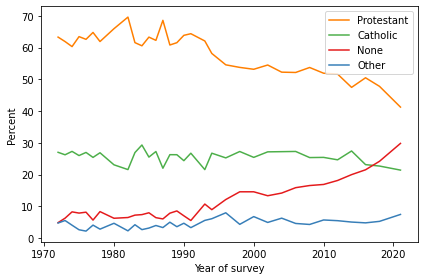

<IPython.core.display.Javascript object>

In [61]:
plot_relig(grouped_year)
decorate(xlabel="Year of survey", ylabel="Percent")

In [62]:
grouped_age = sample.groupby(["age_group"])

<IPython.core.display.Javascript object>

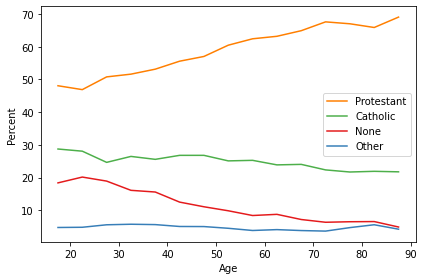

<IPython.core.display.Javascript object>

In [63]:
plot_relig(grouped_age)
decorate(xlabel="Age", ylabel="Percent")

Plot the percentage in each religious group as a function of birth cohort.

In [64]:
grouped_cohort = sample.groupby(["cohort5"])

<IPython.core.display.Javascript object>

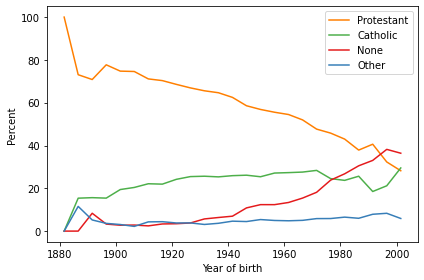

<IPython.core.display.Javascript object>

In [65]:
plot_relig(grouped_cohort)
decorate(xlabel="Year of birth", ylabel="Percent")

## Multinomial models

In [66]:
def make_multi_model(df, var, factors):
    """Fit a multinomial logistic regression model.

    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors

    returns: MNLogit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors + [var])
    y = nonull[var].values
    X = nonull[factors].values
    return MNLogit(y, X).fit(disp=False, full_output=False)

<IPython.core.display.Javascript object>

In [67]:
def make_multi_model_sklearn(df, var, factors):
    """Fit a multinomial logistic regression model.

    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors

    returns: MNLogit model
    """
    nonull = df.dropna(subset=factors + [var])
    X = nonull[factors]
    y = nonull[var]
    result = LogisticRegression(penalty="none").fit(X, y)
    return result

<IPython.core.display.Javascript object>

In [68]:
def predict_multi_model(age, model, year, factors, index):
    """Make a single-year prediction.

    age: Series of ages to simulate
    model: MNLogit model
    year: year to make a prediction for
    factors: list of string names for factors
    index: list of strings, index of result Series

    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)

    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, year=year))
    center_factors(df)

    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)

    # simplification:
    # assume that all respondents have the mean probability for
    # each category, and sample from the multinomial distribution
    # means = pred.mean(axis=0)
    # freqs0 = np.random.multinomial(n, means) / n

    # non-simplification: treat each row as a predictive distribution
    # and draw a sample from each row

    # compute cumulative probabilities along each row
    cumpred = pred.cumsum(axis=1)

    # generate a random value for each row and compare to the
    # cumulative probabilities
    temp = np.random.random(n)[:, None] <= cumpred

    # find the index of the first True in each row
    choices = temp.argmax(axis=1) + 1

    # compute the PMF of the choices
    _, counts = np.unique(choices, return_counts=True)
    freqs = counts / n

    return pd.Series(freqs, index=index) * 100

<IPython.core.display.Javascript object>

In [69]:
train_year = 2018
train = sample[sample.year <= train_year]

<IPython.core.display.Javascript object>

In [70]:
factors = ["ones", "y", "c"]
%time model = make_multi_model_sklearn(train, "relig4", factors)

CPU times: user 2.08 s, sys: 0 ns, total: 2.08 s
Wall time: 369 ms


<IPython.core.display.Javascript object>

In [71]:
factors = ["ones", "y", "c"]
%time model = make_multi_model(train, "relig4", factors)

CPU times: user 676 ms, sys: 3.87 ms, total: 680 ms
Wall time: 112 ms


<IPython.core.display.Javascript object>

In [72]:
age = sample.loc[sample.year == train_year, "age"]
index = ["prot", "cath", "other", "none"]

<IPython.core.display.Javascript object>

In [73]:
predict_multi_model(age, model, 1976, factors, index)

prot     65.783853
cath     24.690303
other     4.143528
none      5.382315
dtype: float64

<IPython.core.display.Javascript object>

In [74]:
predict_multi_model(age, model, 2016, factors, index)

prot     47.330201
cath     25.758223
other     5.425032
none     21.486544
dtype: float64

<IPython.core.display.Javascript object>

In [75]:
predict_multi_model(age, model, 2026, factors, index)

prot     42.973088
cath     24.989321
other     5.510466
none     26.527125
dtype: float64

<IPython.core.display.Javascript object>

In [76]:
predict_multi_model(age, model, 2036, factors, index)

prot     36.010252
cath     21.529261
other     5.553182
none     36.907305
dtype: float64

<IPython.core.display.Javascript object>

In [77]:
def make_multi_pred(df, var, varnames, train_year, years, factors, index):
    """Generate predictions from multinomial model.

    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    train_year: upper bound or (low, high) tuple for years of data
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    index: index for the resulting DataFrame

    returns: DataFrame that maps from index to predicted values
    """
    try:
        low, high = train_year
    except TypeError:
        low = 0
        high = train_year

    train = df[(df.year >= low) & (df.year <= high)]
    age = df.loc[df.year == high, "age"]

    model = make_multi_model(train, var, factors)

    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

<IPython.core.display.Javascript object>

In [78]:
def plot_multi_pred(df, pred, varnames, colors, alpha=0.3):
    """Plots predictions from multinomial model.

    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        series.plot(color=color, alpha=alpha)
    decorate(xlabel="Year of survey")

<IPython.core.display.Javascript object>

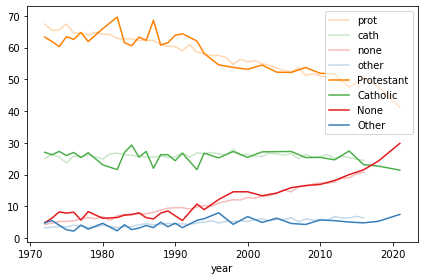

<IPython.core.display.Javascript object>

In [79]:
var = "relig4"
varnames = ["prot", "cath", "none", "other"]
colors = [ORANGE, GREEN, RED, BLUE]
train_year = 2006
years = np.arange(1972, 2017)
index = ["prot", "cath", "other", "none"]

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)
decorate()

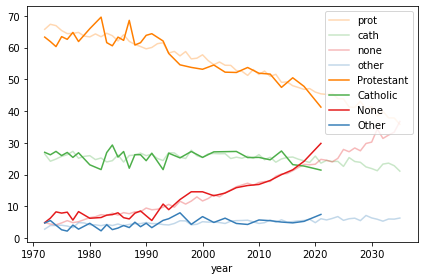

<IPython.core.display.Javascript object>

In [80]:
train_year = 2018
years = np.arange(1972, 2036)

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)

decorate()

## Belief in God

I don't believe in God.....................1 

I don't know whether there is a God and I don''t believe there is any way to find out..................................2

I don't believe in a personal God, but I do believe in a Higher Power of some kind........................3 

I find myself believing in God some of the time, but not at others........4 

While I have doubts, I feel that I do believe in God….............................5 

I know God really exists and I have no doubts about it...........................6

In [81]:
def plot_beliefs(grouped):
    """Plot belief categories.

    grouped: GroupBy object
    """
    varnames = ["strongbelief", "belief", "nobelief"]
    colors = [BLUE, PURPLE, RED]
    labels = ["Strong belief", "Belief", "No belief"]
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

<IPython.core.display.Javascript object>

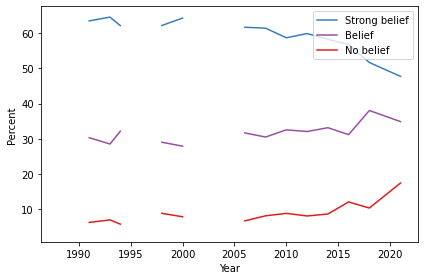

<IPython.core.display.Javascript object>

In [82]:
plot_beliefs(grouped_year)
decorate(xlabel="Year", ylabel="Percent")

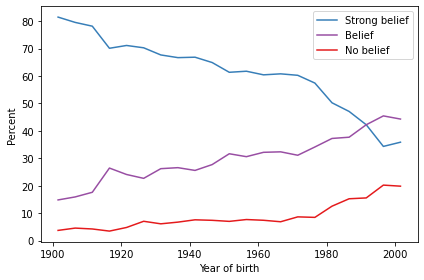

<IPython.core.display.Javascript object>

In [83]:
plot_beliefs(grouped_cohort)
decorate(xlabel="Year of birth", ylabel="Percent")

In [84]:
formula = "belief3 ~ c + y"
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.879184
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                belief3   No. Observations:                27022
Model:                        MNLogit   Df Residuals:                    27016
Method:                           MLE   Df Model:                            4
Date:                Sun, 28 Aug 2022   Pseudo R-squ.:                 0.01638
Time:                        10:08:32   Log-Likelihood:                -23757.
converged:                       True   LL-Null:                       -24153.
Covariance Type:            nonrobust   LLR p-value:                5.970e-170
==============================================================================
 belief3=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7089      0.059     28.919      0.000       1.593       1.825
c             -0.0043      0.001     -3.119      0.002      -0.007      -0.002
y             -0.0230      0.003     -8.303      0.000      -0.028      -0.018
------------------------------------------------------------------------------
 belief3=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2436      0.057     39.559      0.000       2.132       2.355
c             -0.0193      0.001    -14.533      0.000      -0.022      -0.017
y             -0.0225      0.003     -8.517      0.000      -0.028      -0.017
==============================================================================
"""

<IPython.core.display.Javascript object>

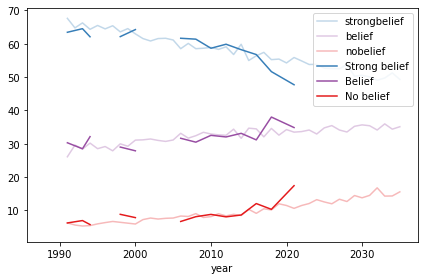

<IPython.core.display.Javascript object>

In [85]:
var = "belief3"
varnames = ["strongbelief", "belief", "nobelief"]
colors = [BLUE, PURPLE, RED]
train_year = 2018
years = np.arange(1991, 2036)
index = ["nobelief", "belief", "strongbelief"]

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_beliefs(grouped_year)

decorate()

In [86]:
make_multi_pred(sample, var, varnames, train_year, [1996, 2016, 2036], factors, index)

,strongbelief,belief,nobelief
1996,63.818881,29.474584,6.706536
2016,57.454079,31.781290,10.764630
2036,47.244767,37.718924,15.036309


<IPython.core.display.Javascript object>

## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [87]:
def plot_conf(grouped):
    """Plot confidence in religion categories.

    grouped: GroupBy object
    """
    varnames = ["confident", "someconf", "noconf"]
    colors = [BLUE, PURPLE, RED]
    labels = ["Great deal", "Only some", "Hardly any"]
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

<IPython.core.display.Javascript object>

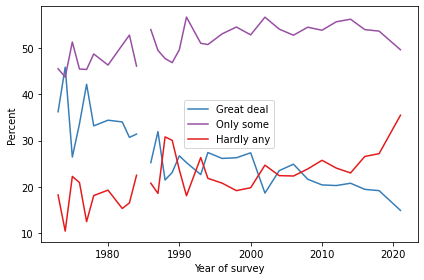

<IPython.core.display.Javascript object>

In [88]:
plot_conf(grouped_year)
decorate(xlabel="Year of survey", ylabel="Percent")

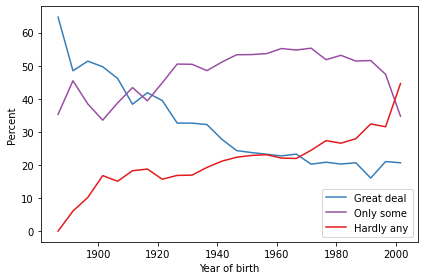

<IPython.core.display.Javascript object>

In [89]:
plot_conf(grouped_cohort)
decorate(xlabel="Year of birth", ylabel="Percent")

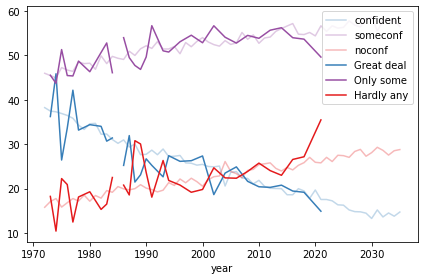

<IPython.core.display.Javascript object>

In [90]:
var = "conclerg"
varnames = ["confident", "someconf", "noconf"]
colors = [BLUE, PURPLE, RED]
train_year = 2018
years = np.arange(1972, 2036)
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_conf(grouped_year)

decorate()

In [91]:
make_multi_pred(sample, var, varnames, train_year, [1976, 2016, 2036], factors, index)

,confident,someconf,noconf
1976,35.155916,46.390431,18.453652
2016,18.453652,55.574541,25.971807
2036,12.772320,58.094831,29.132849


<IPython.core.display.Javascript object>

## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [92]:
def plot_bible(grouped):
    """Plot bible interpretation categories.

    grouped: GroupBy object
    """
    varnames = ["literal", "inspired", "legends"]
    colors = [BLUE, PURPLE, RED]
    labels = ["Literal", "Inspired", "Legends"]
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

<IPython.core.display.Javascript object>

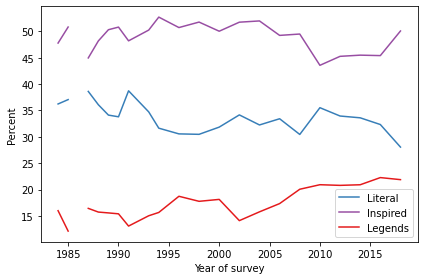

<IPython.core.display.Javascript object>

In [93]:
plot_bible(grouped_year)
decorate(xlabel="Year of survey", ylabel="Percent")

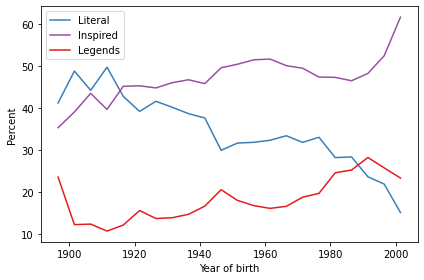

<IPython.core.display.Javascript object>

In [94]:
plot_bible(grouped_cohort)
decorate(xlabel="Year of birth", ylabel="Percent")

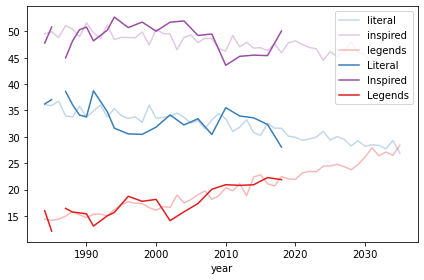

<IPython.core.display.Javascript object>

In [95]:
var = "bible"
varnames = ["literal", "inspired", "legends"]
colors = [BLUE, PURPLE, RED]
train_year = 2018
years = np.arange(1984, 2036)
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_bible(grouped_year)

decorate()

In [96]:
make_multi_pred(sample, var, varnames, train_year, [1986, 2016, 2036], factors, index)

,literal,inspired,legends
1986,33.831696,51.772747,14.395557
2016,33.746262,45.151645,21.102093
2036,28.064930,44.169158,27.765912


<IPython.core.display.Javascript object>

## Resampling

In [97]:
iters = 101
samples = [utils.ResampleByYear(gss) for i in range(iters)]

<IPython.core.display.Javascript object>

In [98]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.

    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names

    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

<IPython.core.display.Javascript object>

In [99]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.

    series_seq: list of sequences
    ps: cumulative probabilities

    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

<IPython.core.display.Javascript object>

In [100]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True):
    """Plots 90% CI and median.

    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            plt.fill_between(xs, rows[0], rows[2], color=color, alpha=0.2)
        if plot:
            plt.plot(xs.to_numpy(), rows[1], color=color, label=label)

<IPython.core.display.Javascript object>

In [101]:
def run_data(df, groupvar, varnames, samples):
    """Resample and extract data.

    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    samples: list of resampled DataFrames
    """

    def run(sample):
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run(sample) for sample in samples]
    return dfs

<IPython.core.display.Javascript object>

In [102]:
def run_model(df, var, varnames, train_year, years, index, samples):
    """Resample and make predictions.

    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    train_year: last year of data to use
    years: list of years to predict
    index: list of string variable names to extract
    iters: number of resamples
    """
    factors = ["ones", "y", "c"]

    def run(sample):
        return make_multi_pred(sample, var, varnames, train_year, years, factors, index)

    dfs = [run(sample) for sample in samples]
    return dfs

<IPython.core.display.Javascript object>

## Affiliation

In [152]:
groupvar = "year"
varnames = ["prot", "cath", "none", "other"]

<IPython.core.display.Javascript object>

In [104]:
dfs1 = run_data(gss, groupvar, varnames, samples)

<IPython.core.display.Javascript object>

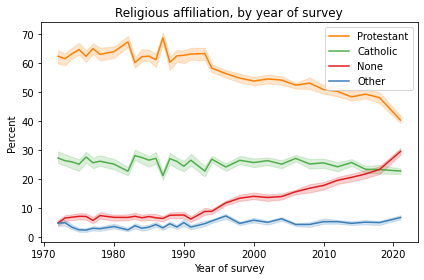

<IPython.core.display.Javascript object>

In [153]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ["Protestant", "Catholic", "None", "Other"]
plot_percentiles(dfs1, varnames, colors, labels)
decorate(
    title="Religious affiliation, by year of survey",
    xlabel="Year of survey",
    ylabel="Percent",
)

savefig("affiliation_year", "png")

In [106]:
groupvar = "cohort5"
dfs2 = run_data(gss, groupvar, varnames, samples)

<IPython.core.display.Javascript object>

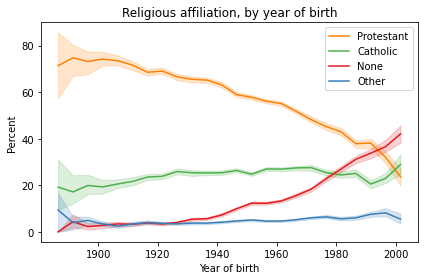

<IPython.core.display.Javascript object>

In [154]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ["Protestant", "Catholic", "None", "Other"]
plot_percentiles(dfs2, varnames, colors, labels)
decorate(
    title="Religious affiliation, by year of birth",
    xlabel="Year of birth",
    ylabel="Percent",
)

savefig("affiliation_cohort", "png")

Train with all data up to 2021 (for new predictions)

In [160]:
var = "relig4"
train_year = 2021
years = np.arange(1972, train_year + 15 + 1)
index = ["prot", "cath", "other", "none"]

<IPython.core.display.Javascript object>

In [161]:
dfs3 = run_model(gss, var, varnames, train_year, years, index, samples)

<IPython.core.display.Javascript object>

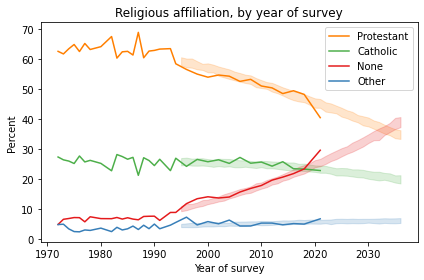

<IPython.core.display.Javascript object>

In [162]:
nolabels = [None] * 4
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
decorate(
    title="Religious affiliation, by year of survey",
    xlabel="Year of survey",
    ylabel="Percent",
)

savefig("affiliation_year_2021", "png")

Train with data up to 2016

In [110]:
train_year = 2016
years = np.arange(1972, train_year + 15 + 1)

<IPython.core.display.Javascript object>

In [111]:
dfs3 = run_model(gss, var, varnames, train_year, years, index, samples)

<IPython.core.display.Javascript object>

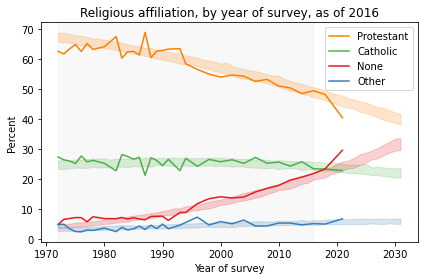

<IPython.core.display.Javascript object>

In [112]:
plt.axvspan(1972, train_year, color="gray", alpha=0.05)

plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
decorate(
    title="Religious affiliation, by year of survey, as of 2016",
    xlabel="Year of survey",
    ylabel="Percent",
)

savefig("affiliation_year_2016", "png")

Train with all data up to 2010

In [113]:
train_year = 2010
years = np.arange(1972, train_year + 15 + 1)

<IPython.core.display.Javascript object>

In [114]:
dfs3 = run_model(gss, var, varnames, train_year, years, index, samples)

<IPython.core.display.Javascript object>

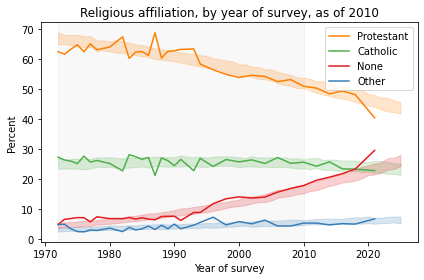

<IPython.core.display.Javascript object>

In [115]:
plt.axvspan(1972, train_year, color="gray", alpha=0.05)

plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
decorate(
    title="Religious affiliation, by year of survey, as of 2010",
    xlabel="Year of survey",
    ylabel="Percent",
)

savefig("affiliation_year_2010", "png")

Train with data up to 2006

In [116]:
train_year = 2006
years = np.arange(1972, train_year + 15 + 1)

dfs4 = run_model(gss, var, varnames, train_year, years, index, samples)

<IPython.core.display.Javascript object>

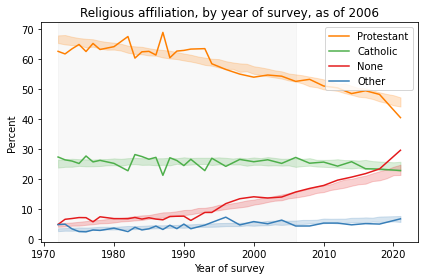

<IPython.core.display.Javascript object>

In [117]:
plt.axvspan(1972, train_year, color="gray", alpha=0.05)

plot_percentiles(dfs4, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
decorate(
    title="Religious affiliation, by year of survey, as of 2006",
    xlabel="Year of survey",
    ylabel="Percent",
)

savefig("affiliation_year_2006", "png")

Train with data up to 2000

In [118]:
train_year = 2000
years = np.arange(1972, train_year + 15 + 1)

dfs4 = run_model(gss, var, varnames, train_year, years, index, samples)

<IPython.core.display.Javascript object>

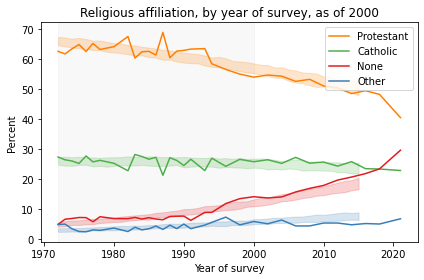

<IPython.core.display.Javascript object>

In [119]:
plt.axvspan(1972, train_year, color="gray", alpha=0.05)

plot_percentiles(dfs4, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
decorate(
    title="Religious affiliation, by year of survey, as of 2000",
    xlabel="Year of survey",
    ylabel="Percent",
)

savefig("affiliation_year_2000", "png")

Train with data up to 1996

In [120]:
train_year = 1996
years = np.arange(1972, train_year + 15 + 1)

dfs4a = run_model(gss, var, varnames, train_year, years, index, samples)

<IPython.core.display.Javascript object>

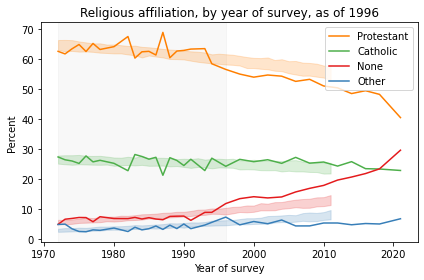

<IPython.core.display.Javascript object>

In [121]:
plt.axvspan(1972, train_year, color="gray", alpha=0.05)

plot_percentiles(dfs4a, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
decorate(
    title="Religious affiliation, by year of survey, as of 1996",
    xlabel="Year of survey",
    ylabel="Percent",
)
savefig("affiliation_year_1996", "png")

In [122]:
ps = np.array([0.5])
series_seq = [df["other"] for df in dfs3]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016]]

,0
1976,3.576678
1986,4.164625
1996,4.752572
2006,5.389515
2016,6.026458


<IPython.core.display.Javascript object>

## Beliefs

In [123]:
groupvar = "year"
varnames = ["strongbelief", "belief", "nobelief"]

<IPython.core.display.Javascript object>

In [124]:
dfs5 = run_data(gss, groupvar, varnames, samples)

<IPython.core.display.Javascript object>

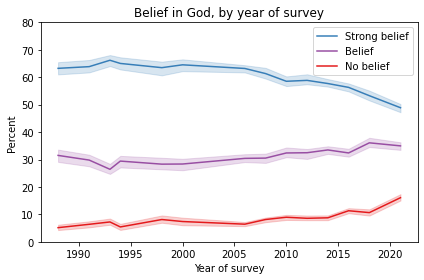

<IPython.core.display.Javascript object>

In [125]:
colors = [BLUE, PURPLE, RED]
labels = ["Strong belief", "Belief", "No belief"]

plot_percentiles(dfs5, varnames, colors, labels)
decorate(
    title="Belief in God, by year of survey",
    xlabel="Year of survey",
    ylabel="Percent",
    ylim=[0, 80],
)

In [126]:
groupvar = "cohort5"
dfs6 = run_data(gss, groupvar, varnames, samples)

<IPython.core.display.Javascript object>

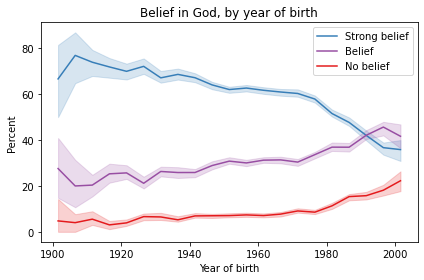

<IPython.core.display.Javascript object>

In [127]:
plot_percentiles(dfs6, varnames, colors, labels)
decorate(
    title="Belief in God, by year of birth",
    xlabel="Year of birth",
    ylabel="Percent",
)

In [128]:
var = "belief3"
train_year = 2018
years = np.arange(1988, 2037)
index = ["nobelief", "belief", "strongbelief"]

<IPython.core.display.Javascript object>

In [129]:
dfs7 = run_model(gss, var, varnames, train_year, years, index, samples)

<IPython.core.display.Javascript object>

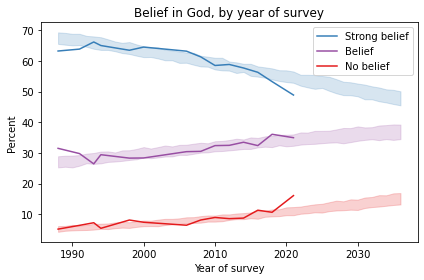

<IPython.core.display.Javascript object>

In [130]:
plot_percentiles(dfs7, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs5, varnames, colors, labels, fill=False)
decorate(
    title="Belief in God, by year of survey",
    xlabel="Year of survey",
    ylabel="Percent",
)

In [131]:
var = "nobelief"
ps = np.array([0.5])
series_seq = [df[var] for df in dfs7]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1996, 2006, 2016, 2026, 2036]]

,0
1996,6.407518
2006,7.902606
2016,9.867578
2026,12.430585
2036,15.079026


<IPython.core.display.Javascript object>

## Confidence

In [132]:
groupvar = "year"
varnames = ["confident", "someconf", "noconf"]

<IPython.core.display.Javascript object>

In [133]:
dfs8 = run_data(gss, groupvar, varnames, samples)

<IPython.core.display.Javascript object>

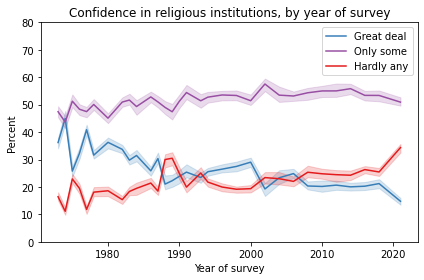

<IPython.core.display.Javascript object>

In [134]:
colors = [BLUE, PURPLE, RED]
labels = ["Great deal", "Only some", "Hardly any"]

plot_percentiles(dfs8, varnames, colors, labels)
decorate(
    title="Confidence in religious institutions, by year of survey",
    xlabel="Year of survey",
    ylabel="Percent",
    ylim=[0, 80],
)

In [135]:
groupvar = "cohort5"
dfs9 = run_data(gss, groupvar, varnames, samples)

<IPython.core.display.Javascript object>

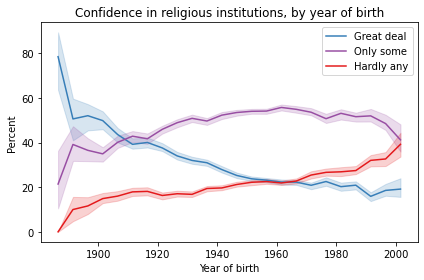

<IPython.core.display.Javascript object>

In [136]:
plot_percentiles(dfs9, varnames, colors, labels)
decorate(
    title="Confidence in religious institutions, by year of birth",
    xlabel="Year of birth",
    ylabel="Percent",
)

In [137]:
var = "conclerg"
train_year = 2018
years = np.arange(1972, 2037)
index = ["confident", "someconf", "noconf"]

<IPython.core.display.Javascript object>

In [138]:
dfs10 = run_model(gss, var, varnames, train_year, years, index, samples)

<IPython.core.display.Javascript object>

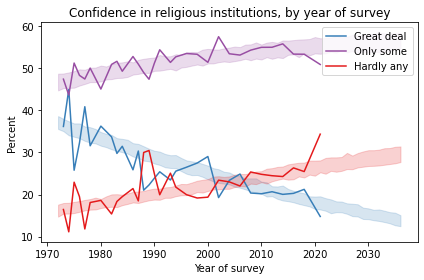

<IPython.core.display.Javascript object>

In [139]:
plot_percentiles(dfs10, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs8, varnames, colors, labels, fill=False)
decorate(
    title="Confidence in religious institutions, by year of survey",
    xlabel="Year of survey",
    ylabel="Percent",
)

In [140]:
var = "noconf"
ps = np.array([0.5])
series_seq = [df[var] for df in dfs10]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,17.214865
1986,19.265271
1996,21.358394
2006,23.494233
2016,25.501922
2026,27.680478
2036,29.944468


<IPython.core.display.Javascript object>

## Bible

In [141]:
groupvar = "year"
varnames = ["inspired", "literal", "legends"]

<IPython.core.display.Javascript object>

In [142]:
dfs11 = run_data(gss, groupvar, varnames, samples)

<IPython.core.display.Javascript object>

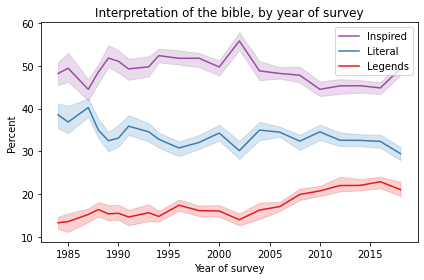

<IPython.core.display.Javascript object>

In [143]:
colors = [PURPLE, BLUE, RED]
labels = ["Inspired", "Literal", "Legends"]

plot_percentiles(dfs11, varnames, colors, labels)
decorate(
    title="Interpretation of the bible, by year of survey",
    xlabel="Year of survey",
    ylabel="Percent",
)

In [144]:
groupvar = "cohort5"
dfs12 = run_data(gss, groupvar, varnames, samples)

<IPython.core.display.Javascript object>

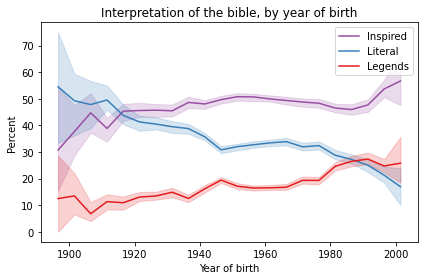

<IPython.core.display.Javascript object>

In [145]:
plot_percentiles(dfs12, varnames, colors, labels)
decorate(
    title="Interpretation of the bible, by year of birth",
    xlabel="Year of birth",
    ylabel="Percent",
)

In [146]:
var = "bible"
train_year = 2018
years = np.arange(1984, 2037)
index = ["literal", "inspired", "legends"]

<IPython.core.display.Javascript object>

In [147]:
dfs13 = run_model(gss, var, varnames, train_year, years, index, samples)

<IPython.core.display.Javascript object>

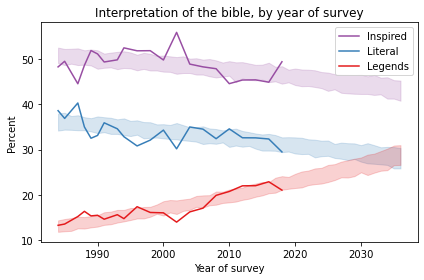

<IPython.core.display.Javascript object>

In [148]:
plot_percentiles(dfs13, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs11, varnames, colors, labels, fill=False)
decorate(
    title="Interpretation of the bible, by year of survey",
    xlabel="Year of survey",
    ylabel="Percent",
)

In [149]:
var = "legends"
ps = np.array([0.5])
series_seq = [df[var] for df in dfs13]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1986, 1996, 2006, 2016, 2026, 2036]]

,0
1986,13.413071
1996,15.805211
2006,18.581803
2016,21.742845
2026,25.117471
2036,29.047416


<IPython.core.display.Javascript object>